# Data extraction

## Libraries

In [ ]:
import os
os.environ['TF_GPU_THREAD_COUNT'] = '5'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
import time
import numpy as np
from joblib import Parallel, delayed
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
import setuptools.dist
from collections import Counter
from skimage.transform import resize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import scipy
from scipy.signal import butter, filtfilt
import pywt
import tensorflow as tf
from tensorflow import keras
import itertools
import seaborn as sns
import tensorflow.python.keras.backend as K
import tsaug as ts
from scipy.ndimage import gaussian_filter
from finta import TA

## Magical formulas to use .mat files

In [2]:
n_subjects = 10
files = [f"S{x}" for x in range(1, n_subjects + 1)]
data = dict()
for file in files:
  E1 = scipy.io.loadmat(f"../data/{file}/{file}_E1_A1.mat")  # Exercise A
  E2 = scipy.io.loadmat(f"../data/{file}/{file}_E2_A1.mat")  # Exercise B
  E3 = scipy.io.loadmat(f"../data/{file}/{file}_E3_A1.mat")  # Exercise C

  # Movimento 0 é o movimento de repouso, então é subtraído 12 e 29 para os experimentos 2 e 3
  E2["stimulus"][np.where(E2["stimulus"] == 0)] = E2["stimulus"][np.where(E2["stimulus"] == 0)] - 12
  E3["stimulus"][np.where(E3["stimulus"] == 0)] = E3["stimulus"][np.where(E3["stimulus"] == 0)] - 29

  data[file] = {
    'emg': np.concatenate([E1["emg"], E2['emg'], E3['emg']]),
    'label': np.concatenate([E1["stimulus"], E2["stimulus"] + 12, E3["stimulus"] + 29]),
    'info': {
      'age': E1['age'],
      'gender': E1['gender'],
      'n_subjects': 10,
      'weight': E1['weight'],
      'height': E1['height'],
      'fs': E1["frequency"][0][0]
    },
    'description': "Contiene datos de EMG de 10 sujetos, 3 experimentos por cada sujeto (E1, E2 y E3) (A, B y C de la figura), cada experimento contiene diferentes ejercicios (A:12, B:17, C:23)."
  }

# Adicionando os dados em um dataframe
df = pd.DataFrame.from_dict(data, orient='index')
print(df)

                                                   emg  \
S1   [[-22.0, -2.0, -16.0, -7.0, -3.0, -1.0, -2.0, ...   
S2   [[-5.0, -1.0, -2.0, -2.0, 1.0, -2.0, 1.0, -3.0...   
S3   [[-5.0, -4.0, -2.0, -1.0, -2.0, -1.0, 0.0, -2....   
S4   [[0.0, -3.0, 1.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1.0...   
S5   [[-2.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 1.0, ...   
S6   [[6.0, -1.0, -2.0, -2.0, 0.0, -1.0, -1.0, -1.0...   
S7   [[-1.0, -2.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0,...   
S8   [[-1.0, -2.0, 1.0, 0.0, 0.0, 0.0, 1.0, -1.0, -...   
S9   [[-2.0, -2.0, 0.0, -1.0, 0.0, -1.0, 0.0, -2.0,...   
S10  [[0.0, -1.0, -1.0, -2.0, -6.0, -4.0, -2.0, 2.0...   

                                                 label  \
S1   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S2   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S3   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S4   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S5   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S6   [[0], [0

In [3]:
df.head()

,emg,label,info,description
S1,"[[-22.0, -2.0, -16.0, -7.0, -3.0, -1.0, -2.0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[23]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S2,"[[-5.0, -1.0, -2.0, -2.0, 1.0, -2.0, 1.0, -3.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S3,"[[-5.0, -4.0, -2.0, -1.0, -2.0, -1.0, 0.0, -2....","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S4,"[[0.0, -3.0, 1.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[22]], 'gender': ['f'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S5,"[[-2.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 1.0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['f'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."


## functions used to get some info

In [4]:
def _rms(data):
	"""
	Root Mean Square.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: RMS feature.
	"""
	return np.sqrt(np.mean(data**2, axis=0))

def _zc(data):
	"""
	Zero Crossing.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: ZC feature.
	"""
	return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0)

def _var(data):
	"""
	Variance.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: Variance feature.
	"""
	return np.var(data, axis=0)

def _mav(data):
	"""
	Mean Absolute Value.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: MAV feature.
	"""
	return np.mean(np.abs(data), axis=0)

def _sscl(data):
	"""
	Slope Sign Change List.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: SSC feature.
	"""
	diff_signal = np.diff(data)
	sign_changes = np.diff(np.sign(diff_signal))
 
	return np.sum(np.abs(np.diff(data, axis=0)), axis=0)

def _wl(data):
	"""
	Waveform Length.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: WL feature.
	"""
	return np.sum(np.abs(np.diff(data, axis=0)), axis=0)


def _hrm(emg_data):
	"""
	Waveform Length.

	Arguments:
			@var emg_data: list of graph data. 

	Returns:
			@return: HRM feature.
	"""

	return np.mean(np.sqrt(np.abs(emg_data)), axis=0)


#### Faltam testes com a ren com os parâmetros ideais
def _ren(data, m=100, tolerance=50):
    n = len(data)
    
    # Verificar se o comprimento dos dados permite a execução
    if n < m:
        return 0
    
    # Cria uma matriz com todos os segmentos de tamanho `m`
    segments = np.array([data[i:i + m] for i in range(n - m + 1)])
    
    # Calcula as diferenças absolutas entre todos os pares de segmentos
    diffs = np.abs(segments[:, np.newaxis] - segments)
    # Verifica se todas as diferenças dentro de cada par são <= tolerance
    matches = np.all(diffs <= tolerance, axis=2)
    
    # Conta as correspondências, subtrai 1 para não contar o próprio segmento
    count = np.sum(matches) - (n - m + 1)
    
    # Calcula o número total de combinações possíveis
    total_combinations = (n - m) * (n - m + 1) / 2
    
    # Calcula a entropia aproximada
    rough_entropy_value = -np.log(count / total_combinations) if count > 0 else 0
    return rough_entropy_value

### Signal filters

#### Butterworth bandpass

In [5]:
def butterworth_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butterworth_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#### Wavelet transform

In [6]:
def wavelet_transform(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

## Training dataset

### Extract features

In [5]:
def mk_features(emg_df):
    ftrs = ['rms', 'zc', 'var', 'mav', 'sscl', 'wl', 'hrm']
    n_channels = 16
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in ftrs]
    columns.append('label')
    features_df = pd.DataFrame(columns=columns)
    
    def process(window, n_channels=16):
        row = {}
        label = np.array(window['label'])
        mostCommonLabel = Counter(label.flatten().astype(int).tolist()).most_common(1)[0][0]
    
        for i in range(n_channels):
            channel_data = window[f'emg_{i+1}']
    
            rms = _rms(channel_data)
            zc = _zc(channel_data)
            var = _var(channel_data)
            mav = _mav(channel_data)
            sscl = _sscl(channel_data)
            wl = _wl(channel_data)
            hrm = _hrm(channel_data)
    
            row[f'rms_{i+1}'] = rms
            row[f'zc_{i+1}'] = zc
            row[f'var_{i+1}'] = var
            row[f'mav_{i+1}'] = mav
            row[f'sscl_{i+1}'] = sscl
            row[f'wl_{i+1}'] = wl
            row[f'hrm_{i+1}'] = hrm
    
        row['label'] = mostCommonLabel
        return row
    
    window_size = 200
    step = 25
    windows = emg_df.rolling(window=window_size, step=step)
    results = Parallel(n_jobs=-1)(delayed(process)(window, n_channels=n_channels) for window in windows if len(window) == window_size)
    
    return pd.DataFrame(results, columns=columns)

In [6]:
emg_data = []
for index, row in df.iterrows():
    for i, emg in enumerate(row['emg']):
        emg_data.append({ 'emg': emg, 'label': row['label'][i] })

In [7]:
emg_df = pd.DataFrame(emg_data)

# adicionar colunas separadas para cada canal de EMG
for i in range(16):
    emg_df[f'emg_{i+1}'] = emg_df['emg'].apply(lambda x: x[i] if i < len(x) else np.nan)

# remover a coluna original 'emg'
emg_df.drop(columns=['emg'], inplace=True)

features_df = mk_features(emg_df)
features_df.head()

,rms_1,zc_1,var_1,mav_1,sscl_1,wl_1,hrm_1,rms_2,zc_2,var_2,...,wl_15,hrm_15,rms_16,zc_16,var_16,mav_16,sscl_16,wl_16,hrm_16,label
0,10.748721,115,115.023773,6.685,2096.0,2096.0,2.187962,19.061743,123,361.910004,...,556.0,1.203651,6.166847,98,36.948399,4.270,1175.0,1175.0,1.779411,0
1,9.144124,116,83.359978,5.395,1665.0,1665.0,1.943728,9.358151,118,86.958778,...,322.0,1.033981,5.523133,93,29.919775,3.845,937.0,937.0,1.681454,0
2,7.553476,114,56.340977,4.175,1232.0,1232.0,1.681269,7.719132,118,59.044773,...,291.0,0.972428,4.930517,98,23.500000,3.380,783.0,783.0,1.554758,0
3,5.574047,111,30.277901,3.330,952.0,952.0,1.542950,6.489222,122,41.149601,...,280.0,0.971386,4.307551,94,17.680775,3.035,624.0,624.0,1.480748,0
4,5.502272,114,29.594376,3.225,914.0,914.0,1.506509,5.808184,122,32.600777,...,260.0,0.950279,3.952847,93,14.574375,2.765,583.0,583.0,1.413978,0


### Train and test cases

#### Cross-validation test

In [8]:
# Make the cross-validation of train data
def cross_validation(model, X, y, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    return scores

# Train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Train and evaluate the model with cross-validation
def train_and_evaluate_model_cv(model, X, y, cv=5):
    scores = cross_validation(model, X, y, cv=cv)
    return

### Using ML techniques

In [26]:
ml_df = features_df.copy()
X = ml_df.drop(columns=['label'])
y = ml_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
train_and_evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=10, min_sa

In [ ]:
# plot the validation curve
def plot_validation_curve(model, X, y, param_name, param_range, cv=5):
    train_scores, test_scores = validation_curve(model, X, y, param_name=param_range, cv=cv, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)

    plt.legend(loc="best")
    plt.show()

# plot the learning curve
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.plot(train_sizes, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)

    plt.legend(loc="best")
    plt.show()

In [ ]:
# plots for random forest model
best_model_random_forest = best_model
y_pred_random_forest = y_pred
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)

plot_validation_curve(best_model_random_forest, X_train_scaled, y_train, 'n_estimators', [100, 200, 300])
plot_learning_curve(best_model_random_forest, X_train_scaled, y_train)


In [ ]:
# Using SVM model
model = SVC(kernel='linear', C=1, random_state=42)
train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
train_and_evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

In [ ]:
best_model_svm = best_model
y_pred_svm = y_pred
accuracy_svm = accuracy_score(y_test, y_pred_svm)

plot_validation_curve(best_model_svm, X_train_scaled, y_train, 'C', [0.1, 1, 10, 100])
plot_learning_curve(best_model_svm, X_train_scaled, y_train)

In [ ]:
# Using KNN model
model = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
train_and_evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

In [ ]:
best_model_knn = best_model
y_pred_knn = y_pred
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_knn = accuracy_knn * 100

plot_validation_curve(best_model_knn, X_train_scaled, y_train, 'n_neighbors', [5, 10, 15, 20])
plot_learning_curve(best_model_knn, X_train_scaled, y_train)

In [ ]:
# Using Lasso model
model = Lasso(alpha=0.1)
train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
train_and_evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

In [ ]:
best_model_lasso = best_model
y_pred_lasso = y_pred
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

plot_validation_curve(best_model_lasso, X_train_scaled, y_train, 'alpha', [0.1, 0.5, 1, 5, 10])
plot_learning_curve(best_model_lasso, X_train_scaled, y_train)

In [ ]:
# Using CNN model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model = build_model(input_shape=(X_train_reshaped.shape[1], 1))
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)

y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
best_model_cnn = model
y_pred_cnn = y_pred
accuracy_cnn = accuracy

plot_learning_curve(best_model_cnn, X_train_reshaped, y_train)
plot_validation_curve(best_model_cnn, X_train_reshaped, y_train, 'epochs', [10])

In [ ]:

# Using LSTM model
def build_lstm_model(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

model = build_lstm_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)

y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Plot about the models
models = ['Random Forest', 'SVM', 'KNN', 'Lasso', 'CNN', 'LSTM']

# Get the accuracies from classification reports
mean_accuracies = [0.96, 0.95, 0.94, 0.93, 0.95, 0.94]

plt.figure(figsize=(10, 5))
plt.bar(models, mean_accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy of Models')
plt.show()

### Using DL techniques

In [21]:
dl_df = features_df.copy()
X = dl_df.drop(columns=['label'])
y = dl_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
y_train_parsed = keras.utils.to_categorical(y_train)
y_test_parsed = keras.utils.to_categorical(y_test)

model = keras.models.Sequential()
model.add(keras.layers.Dense(2056, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(1028, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
history = model.fit(
  X_train,
  y_train_parsed,
  epochs=300,
  batch_size=5500,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

c:\Users\Gabriel_Germano\Documents\sEMG\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.8334481062469258
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     20469
           1       0.92      0.76      0.83       550
           2       0.88      0.83      0.86       598
           3       0.89      0.89      0.89       584
           4       0.86      0.84      0.85       637
           5       0.85      0.89      0.87       590
           6       0.77      0.86      0.81       579
           7       0.96      0.70      0.81       618
           8       0.96      0.71      0.81       573
           9       0.90      0.76      0.82       556
          10       0.91      0.79      0.84       680
          11       0.80      0.83      0.82       594
          12       0.91      0.76      0.83       582
          13       0.84      0.88      0.86       574
          14       0.82      0.85      0.84       557
          15       0.90      0.79      0.84       559
         

c:\Users\Gabriel_Germano\Documents\sEMG\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Accuracy: 0.5403049680275455
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     20469
           1       0.33      0.50      0.40       550
           2       0.67      0.40      0.50       598
           3       0.42      0.26      0.32       584
           4       0.76      0.41      0.53       637
           5       0.76      0.43      0.55       590
           6       0.45      0.31      0.36       579
           7       0.45      0.21      0.28       618
           8       0.59      0.20      0.30       573
           9       0.65      0.28      0.40       556
          10       0.49      0.16      0.24       680
          11       0.66      0.42      0.51       594
          12       0.60      0.37      0.46       582
          13       0.80      0.45      0.57       574
          14       0.40      0.42      0.41       557
          15       0.72      0.39      0.50       559
       

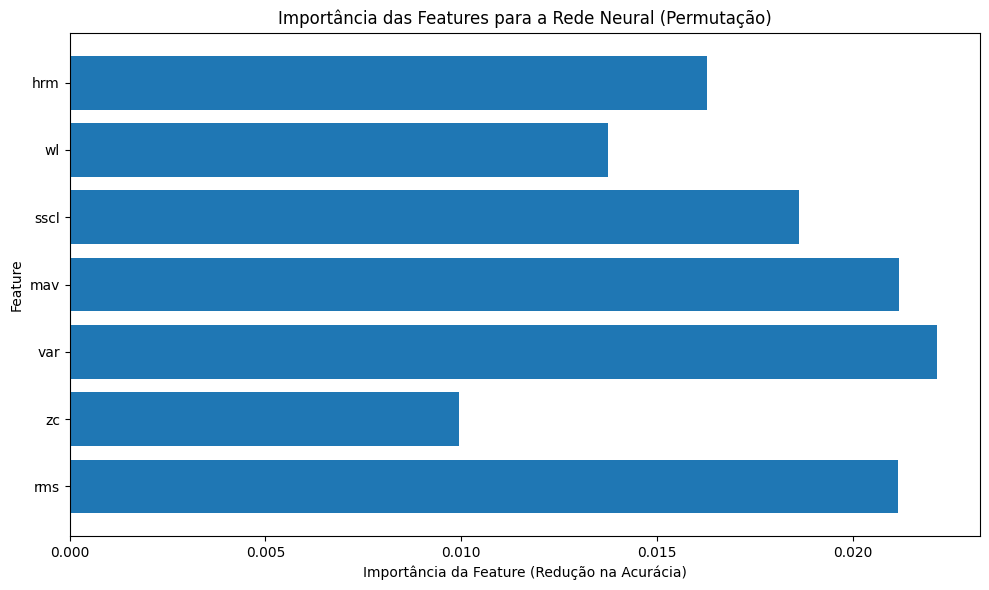

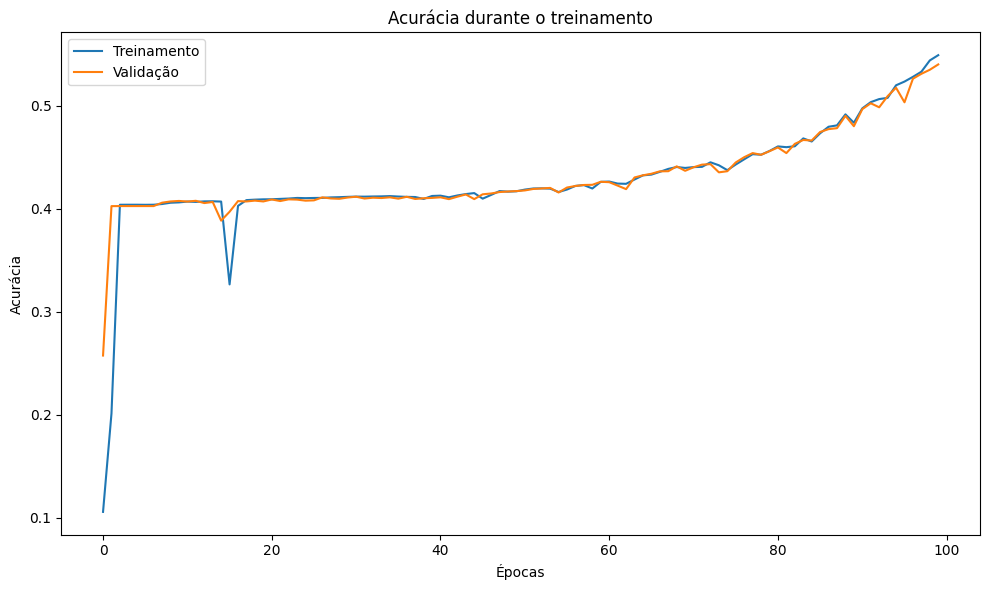

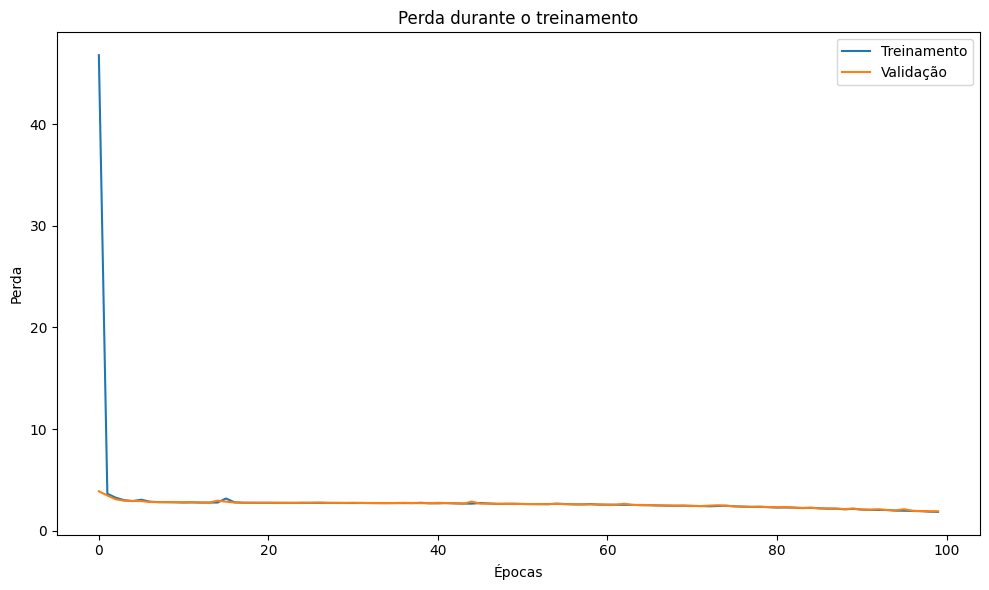

In [23]:
y_train_parsed = keras.utils.to_categorical(y_train)
y_test_parsed = keras.utils.to_categorical(y_test)

model = keras.models.Sequential()
model.add(keras.layers.Dense(1028, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history = model.fit(
    X_train,
    y_train_parsed,
    epochs=100,
    batch_size=5500,
    validation_data=(X_test, y_test_parsed),
    verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)

print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

def permutation_importance(model, X_test, y_test_classes, baseline_accuracy):
    importances = np.zeros(X_test.shape[1])
    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted.iloc[:, i].values)  # Permutar a coluna i
        # Fazer predições com a feature permutada
        y_permuted_pred = model.predict(X_test_permuted)
        y_permuted_classes = np.argmax(y_permuted_pred, axis=1)

        # Calcular a acurácia com a feature permutada
        permuted_accuracy = accuracy_score(y_test_classes, y_permuted_classes)
        importances[i] = baseline_accuracy - permuted_accuracy
        
    return importances

# Calcular as importâncias das features
importances = permutation_importance(model, X_test, y_test_classes, baseline_accuracy)

features_mean = [0 for _ in range(int(len(importances)/16))]

for fm in range(len(features_mean)):
    features_mean[fm] = np.mean(importances[fm*16:(fm+1)*16])

importances = features_mean

feature_names = []

for i in range(0,len(features_mean)):
    name = X_train.keys()[i].split("_")[0]
    feature_names.append(name)

# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Importância da Feature (Redução na Acurácia)")
plt.ylabel("Feature")
plt.title("Importância das Features para a Rede Neural (Permutação)")
plt.tight_layout()
plt.savefig("./plots/feature_importance.png")
plt.show()

# Plotar a acurácia durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/training_accuracy.png")
plt.show()

# Plotar a perda durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/training_loss.png")
plt.show()

In [ ]:
# data normalization
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# using cnn model
cnn_model = keras.models.Sequential()
cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(3, activation='softmax'))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=1)

y_pred_cnn = cnn_model.predict(X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1))
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

print(f'\nCNN Accuracy: {accuracy_score(y_test_classes, y_pred_classes_cnn)}')
print(classification_report(y_test_classes, y_pred_classes_cnn))